# Permeation barrier model

Base model for shield permeation barrier modeling

In [30]:
import festim as F
import numpy as np
from timelag_analysis_functions import *

In [31]:
print(F.__version__)

2.0a7


In [32]:
my_model = F.HydrogenTransportProblem()

substrate_thick = 1e-3  # m
my_model.temperature = 600
w_atom_density = 6.3e28  # atom/m3
final_time = 1.2e5  # s

tungsten = F.Material(
    D_0=4.1e-7,
    E_D=0.39,
    K_S_0=1.87e24,
    E_K_S=1.04,
    )

In [33]:
import ufl

# ---- User inputs ----
run_length = 1.6e5 # s
bake_length = 3.6e5 # s
n_runs = 6 # arbitrary number of runs

P_run = 1.0e5 # pressure during runs (Pa)
P_bake = 0.0 # pressure during bakes (Pa)

# ---- Build milestones and final_time ----
milestones = []
t_curr = 0.0
for i in range(n_runs):
    # end of run i
    t_curr += run_length
    milestones.append(t_curr)
    # end of bake i (for all but the last run)
    if i < n_runs - 1:
        t_curr += bake_length
        milestones.append(t_curr)

# total simulated time
final_time = t_curr
# (equivalently: final_time = n_runs * run_length + (n_runs - 1) * bake_length)


def _build_pressure_expr(t, milestones, P_run, P_bake):
    """
    Internal helper that actually builds the nested ufl.conditional expression.
    FESTIM never inspects this function.
    """
    expr = P_run  # fallback after last milestone: run
    for k in reversed(range(len(milestones))):
        is_run = (k % 2 == 0)          # even index → run, odd → bake
        value_here = P_run if is_run else P_bake
        expr = ufl.conditional(
            ufl.le(t, milestones[k]),
            value_here,
            expr,
        )
    return expr


def P_up(t):
    """
    Pressure function with FESTIM-compatible signature and co_varnames.
    Only argument is `t`, and body is a single return statement.
    """
    return _build_pressure_expr(t, milestones, P_run, P_bake)

In [34]:

H, trapped_H1, trapped_H2, empty_trap1, empty_trap2 = define_species(my_model, w_atom_density)

vertices = np.linspace(0, substrate_thick, num=50)

my_model.mesh = F.Mesh1D(vertices)

volume_subdomain, left_boundary, right_boundary = define_BCs_and_initial_conditions(my_model, tungsten, substrate_thick, H, P_up)

define_trapping_reactions(my_model, H, trapped_H1, trapped_H2, empty_trap1, empty_trap2, volume_subdomain, w_atom_density)

settings(my_model, final_time, milestones=milestones)

permeation_flux = F.SurfaceFlux(field=H, surface=right_boundary)

my_model.exports = [permeation_flux]

total_trapped_H1 = F.TotalVolume(field=trapped_H1, volume=volume_subdomain)

# left_flux = F.SurfaceFlux(surface=left_boundary, field=H)
# right_flux = F.SurfaceFlux(surface=right_boundary, field=H)
# total_mobile_H = F.TotalVolume(field=H, volume=volume_subdomain)
# total_trapped_H1 = F.TotalVolume(field=trapped_H1, volume=volume_subdomain)
# total_trapped_H2 = F.TotalVolume(field=trapped_H2, volume=volume_subdomain)


my_model.initialise()

my_model.run()



# profile_exports = [
#     F.Profile1DExport(
#         field=spe,
#     )
#     for spe in [H, trapped_H1, trapped_H2]
# ]

# my_model.exports = [
#     total_mobile_H,
#     total_trapped_H1,
#     total_trapped_H2,
#     left_flux,
#     right_flux,
# ] + profile_exports

Solving HydrogenTransportProblem: 100%|██████████| 2.76M/2.76M [01:08<00:00, 40.1kit/s]


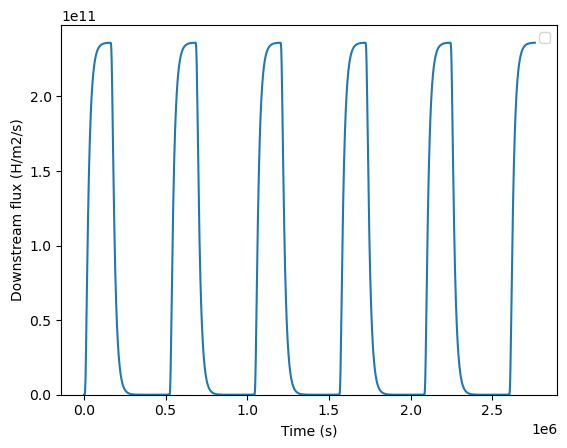

In [35]:
times = permeation_flux.t

import matplotlib.pyplot as plt

plt.plot(times, np.abs(permeation_flux.data))
plt.ylim(bottom=0)
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m2/s)")
plt.legend()
plt.show()

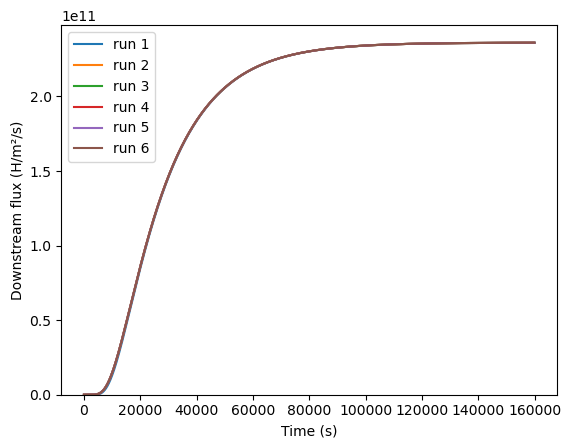

In [36]:
import numpy as np
import matplotlib.pyplot as plt

times = np.asarray(times)
flux  = np.asarray(permeation_flux.data)

# milestones: [run1_end, bake1_end, run2_end, bake2_end, ..., runN_end]
# length = 2*n_runs - 1
milestones = np.asarray(milestones)

# ---------------------------------------
# Split into segments (runs and bakes)
# ---------------------------------------
segments = []  # each item: (segment_type, times, flux)

t_prev = 0.0

for k, m in enumerate(milestones):
    # even k = run segment, odd k = bake segment
    is_run = (k % 2 == 0)
    seg_type = "run" if is_run else "bake"

    mask = (times > t_prev) & (times <= m)

    seg_times = times[mask]
    seg_flux  = flux[mask]

    segments.append((seg_type, seg_times, seg_flux))

    t_prev = m  # update previous milestone


# ---------------------------------------
# Extract only the runs for plotting
# ---------------------------------------
run_segments = [(t, f) for (typ, t, f) in segments if typ == "run"]

plt.figure()

for i, (t_seg, f_seg) in enumerate(run_segments, start=1):
    # shift second+ runs to start at zero
    if i == 1:
        t_plot = t_seg
    else:
        t_plot = t_seg - t_seg[0]

    plt.plot(t_plot, np.abs(f_seg), label=f"run {i}")

plt.ylim(bottom=0)
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m²/s)")
plt.legend()
plt.show()

Max flux (run 1): 2.361e+11
Threshold (5.0%): 1.180e+10


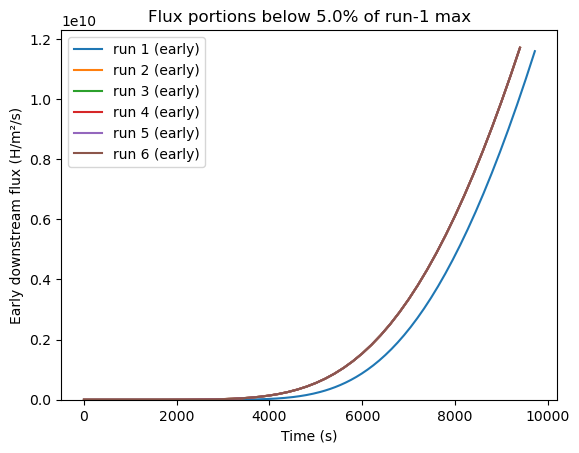

In [37]:
pct = 0.05  # e.g., % of the maximum flux from run 1

# ---- Step 1: compute threshold based on run 1 ----
run1_times, run1_flux = run_segments[0]
max_flux_run1 = np.max(np.abs(run1_flux))
threshold = pct * max_flux_run1

print(f"Max flux (run 1): {max_flux_run1:.3e}")
print(f"Threshold ({pct*100:.1f}%): {threshold:.3e}")

# ---- Step 2: extract "early flux" region for each run ----
early_run_segments = []

for i, (t_seg, f_seg) in enumerate(run_segments, start=1):
    f_abs = np.abs(f_seg)
    mask = f_abs <= threshold

    t_early = t_seg[mask]
    f_early = f_abs[mask]

    early_run_segments.append((t_early, f_early))


# ---- Step 3: plot only the early portions ----
plt.figure()

for i, (t_early, f_early) in enumerate(early_run_segments, start=1):
    if len(t_early) == 0:
        continue

    # Shift runs 2+ to start at zero
    if i == 1:
        t_plot = t_early
    else:
        t_plot = t_early - t_early[0]

    plt.plot(t_plot, f_early, label=f"run {i} (early)")

plt.ylim(bottom=0)
plt.xlabel("Time (s)")
plt.ylabel("Early downstream flux (H/m²/s)")
plt.title(f"Flux portions below {pct*100}% of run-1 max")
plt.legend()
plt.show()